<a href="https://colab.research.google.com/github/ChaejinE/MyPytorch/blob/main/e_AutoGrad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
- 학습시 가장 자주 사용되는 알고리즘은 Back-Propagation
  - wieghts는 손실함수의 gradient에 따라 조정된다.
- gradient 계산을 위해 torch.autograd라고 불리는 자동 미분  엔진이 내장되어 있다.

In [1]:
import torch

In [2]:
x = torch.ones(5) # simple input
y = torch.zeros(3) # simple expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w) + b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

# Computational graph
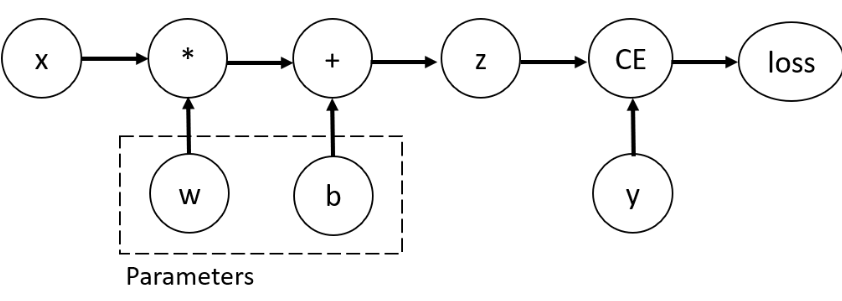
- 연산 그래프 정의
- w, b 는 최적화 해야하는 매개변수다.
- 이러한 변수들에 대한 손실 함수의 gradient를 계산할 수 있어야 한다.
  - 해당 텐서에 requires_grad 속성을 설정한다.
  - 보통 x.requires_grad(True)로 텐서 생성 시 적용한다.
  - x.requires_grad_(True) 메소드로 나중에 설정도 가능하다.
- 연산 그래프를 구성하기 위해 텐서에 적용되는 함수는 **Function** 클래스 객체다.
  - 순전파 방향으로 함수 계산하는 방법
  - 역방향 derivative 게산하는 방법
  - 위 방법을 둘다 알고 있는 클래스 객체다.
  - 역방향 전파 함수에 대한 reference는 grad_fn 속성에 저장된다.

In [3]:
print("Gradient function for z = ", z.grad_fn)
print("Gradient function for loss = ", loss.grad_fn)

Gradient function for z =  <AddBackward0 object at 0x7f844a8da150>
Gradient function for loss =  <BinaryCrossEntropyWithLogitsBackward object at 0x7f844a8dad50>


- Gradient 계산
  - 일부 고정 값에서 loss/w, loss/b 형태의 편미분이 필요하다.
  - loss.backward()를 호출한 다음 w.grad, b.grad에서 값을 가져온다.
- 연산 그래프의 Node들 중 requires_grad 속성이 True로 설정된 노드들의 grad 속성만 구할 수 있다.
- 성능 상 이유로 backward를 사용한 gradient 계산은 한 번만 수행할 수 있다.
  - 만약 동일 그래프에서 여러번의 backward 호출이 필요하면 backward 호출 시 retain_graph=True를 전달해야한다.


In [5]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.0812, 0.2661, 0.1284],
        [0.0812, 0.2661, 0.1284],
        [0.0812, 0.2661, 0.1284],
        [0.0812, 0.2661, 0.1284],
        [0.0812, 0.2661, 0.1284]])
tensor([0.0812, 0.2661, 0.1284])


# Gradient tracking 멈추기
- 기본적으로 requires_grad=True의 모든 텐서들은 연산기록을 추적하고 gradient 계산을 지원한다.
- 데이터만 단순히 적용하는 경우, 순전파 연산만 필요한 경우 추적이나 지원이 필요없을 수 있으므로 torch.no_grad() 블록으로 둘러싸서 연산추적을 멈출 수 있다.
- 왜멈추는가?
  - fine tuning 시 frozen paramter가 필요
  - 순전파 단계 수행 때 연산 속도 향상

In [6]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w) + b
print(z.requires_grad)

True
False


In [9]:
# stop gradient tracking 다른 방법
z = torch.matmul(x, w) + b
print(z.requires_grad)
z_det = z.detach()
print(z_det.requires_grad)

True
False


# 연산그래프 Detail
- 기본적으로 tensor의 모든 연산 -> 기록은 Function 객체로 구성된 비순환 그래프에 저장한다.
  - DAG : Directed Acyclic Graph (비순환 그래프
  - DAG의 leaf(Node) : 입력 텐서
  - DAG의 root : 결과 텐서
  - DAG의 root에서 leaf까지 Traking하면 chaine rule에 따라 gradient를 자동으로 계산할 수 있다.
- 순전파 시 autograd 작업
  - 1. 요청된 연산을 수행 -> 결과 텐서 계산
  - 2. DAG에 연산의 gradient function을 유지
  - 위 두가지는 동시에 수행된다.
- 역전파 시 autograd 작업
  - 1. 각 .grad_fn 으로 부터 변화도 계산
  - 2. 각 텐서의 .grad 속성에 계산결과를 accumulate
  - 3. chain rule을 사용해 모든 node tensor들까지 propagate
  - 위 연산들은 DAG root에서 .backward()가 호출될 때 시작한다.
# DAG Detail
- DAG는 PyTroch에서 dynamic이다.
  - 중요한점 : 그래프가 처음부터 다시 생성된다.
  - 매번 backward()호출 시 autograd는 새로운 그래프를 populate(채우기)시작한다.
  - 이런 점때문에 model에서 control flow(흐름제어) 구문들을 사용할 수 있게 되는 것이다.
  - 매번 iteration 할때마다 필요하면 shape, size, operation을 바꿀 수 있다.

# Optional Reading : Tensor Gradient & Jacobian Product
- 대부분의 경우 스칼라 손실 함수를 가지고 일부 매개변수와 관련한 gradient를 계산해야한다.
- 그러나 출력함수가 임의의 Tensor인 경우가 있다.
  - 이럴때 PyTorch는 실제 변화도가 아닌 Jacobian product을 게산한다.
- X = (x1,...,xn), Y = (y1,...,yn)일 때,
- Y = F(X)에서 X에대한 Y의 gradient는 Jacobian matrix로 주어진다.

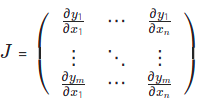
- Jacobian matrix 자체를 계산하는 대신 PyTorch는 주어진 입력벡터 V=(v1,...,vn)에 대한 Jacobian Product, V.T * J를 계산한다.
  - V를 인자로 backward를 호출하면 이뤄진다.
  - V의 크기는 Product을 계산하려고 하는 원래 텐서의 크기와 같아야한다.

In [11]:
inp = torch.eye(5, requires_grad=True)
inp

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]], requires_grad=True)

In [13]:
out = (inp+1).pow(2)
out

tensor([[4., 1., 1., 1., 1.],
        [1., 4., 1., 1., 1.],
        [1., 1., 4., 1., 1.],
        [1., 1., 1., 4., 1.],
        [1., 1., 1., 1., 4.]], grad_fn=<PowBackward0>)

In [14]:
out.backward(torch.ones_like(inp), retain_graph=True)
print("First call\n", inp.grad)

First call
 tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.],
        [2., 2., 2., 2., 4.]])


In [15]:
out.backward(torch.ones_like(inp), retain_graph=True)
print("Second call\n", inp.grad)

Second call
 tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.],
        [4., 4., 4., 4., 8.]])


In [16]:
inp.grad.zero_()
inp

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]], requires_grad=True)

In [17]:
out.backward(torch.ones_like(inp), retain_graph=True)
print("Call after zeroing gradients\n", inp.grad)

Call after zeroing gradients
 tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.],
        [2., 2., 2., 2., 4.]])


- 동일한 인자로 backward를 두차례 호출하면 변화도 값이 달라진다.
  - 이는 Backpropagation 수행 시 PyTorch가 Gradient를 Accumulate해두기 때문이다.
  - 즉, 계산된 Gradient 값이 연산 그래프의 모든 Node의 grad 속성에 추가된다.
- 제대로된 gradient 계산을 위해서는 grad 속성을 먼저 0으로 만들어야한다.
- 실제 학습 과정에서는 Optimizer가 이 과정을 도와준다.